<h1> Code documentation for the thesis "The potential of batteries to increase the self consumption ratio of a net-energy-positive high-rise building in the Netherlands. </h1>

 <h2> Input Data </h2>

For the ten story building in Utrecht Overvecht in the Henriettendreef a dataset for 2022 was provided. The Dataset entailed hourly values in the unit of kWh for the following flows of electricity: 
- Production (The amount of electricity produced by the solar panels)
- Usage (The amount of electricity consumed from the grid)
- Return (The amount of electricity fed into the grid)

When conduction a visul inspection of the data by plotting a graph it was noticed that there were unrealisitcially high values in production as well as consumption and production values below zero, which is not possible.
After closer inspection of the input-data it was discovered that the data for a 12 day preriod in july appeared to be wrong, so it was decided to replace those 12 days with data from the respective days from year 2021.

 <h2> Adapting the structure of the input data to make analysis and manipulation easier </h2>

The data was provided in the form of 365 csv files (one for each day of the year). The files are structured in a way where for each data-point had a it's own row. Meaning that for every flat and the two facilites, each data-type (kWhReturnedLow, kWhReturnedNormal, PV_kWh - PV5_kWh, kWhUsedNormal, kWhUsedLow) and each hour a seperate row exists. In total this resulted in more than 2.6 million rows.

The aim of this thesis was to analyise the house as a whole and perform several analyses hour per hour. Therefore, the first step was to create a dataframe with one row for each hour of the year (8760) and columns for production, usage and return (from here on called feed-in). Therefore, the first part of the code is dedicated to the transformation of the data to make it more easily workable.

In [165]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

#Create a datafram with all 365 CSVs inside
file_list = glob.glob('/Users/lennartwittstock/Downloads/Thesis/Data/Hourly_data/*.csv')
dfs = []

for file in file_list:
    df = pd.read_csv(file)
    dfs.append(df)
combined_df = pd.concat(dfs, ignore_index=True)



#Creaetind DF with only the feed-in values
    # Filtering only for electricity fed into the grid
feed_in_datatypes = ["kWhReturnedLow", "kWhReturnedNormal"]
feed_in_df = combined_df[combined_df["Datatype"].isin(feed_in_datatypes)]
    # Merging the flats and facilities into one
agg_functions = {'Tijdstip': 'first', 'Waarde': 'sum' }
merged_feed_in_df = feed_in_df.groupby(feed_in_df['Tijdstip']).aggregate(agg_functions)
    #Remaning the coloumn
merged_feed_in_df.rename(columns={'Waarde':'Feed_in_values'}, inplace=True)  
    # Changing the datetime format to match pythons standard
merged_feed_in_df['Tijdstip'] = pd.to_datetime(merged_feed_in_df['Tijdstip'])
    #Set the timestamp as index
merged_feed_in_df.set_index('Tijdstip', inplace=True)



#Creaetind DF with only the usage values
usage_datatypes= ["kWhUsedNormal", "kWhUsedLow"]
usage_df = combined_df[combined_df["Datatype"].isin(usage_datatypes)]
    # Merging the flats and facilities into one
agg_functions = {'Tijdstip': 'first', 'Waarde': 'sum' }
merged_usage_df = usage_df.groupby(usage_df['Tijdstip']).aggregate(agg_functions)
    # Remane the coloumn
merged_usage_df.rename(columns={'Waarde':'Usage_values'}, inplace=True)
    # Changing the datetime format to match pythons standard
merged_usage_df['Tijdstip'] = pd.to_datetime(merged_usage_df['Tijdstip'])
    #Set the timestamp as index
merged_usage_df.set_index('Tijdstip', inplace=True)



#Creaetind DF with only the production values
production_datatypes= ["PV_kWh", "PV1_kWh","PV2_kWh" ,"PV3_kWh", "PV4_kWh", "PV5_kWh"]
production_df = combined_df[combined_df["Datatype"].isin(production_datatypes)]
    # Merging the flats and facilities into one
agg_functions = {'Tijdstip': 'first', 'Waarde': 'sum' }
merged_production_df = production_df.groupby(production_df['Tijdstip']).aggregate(agg_functions)
    # Remane the coloumn
merged_production_df.rename(columns={'Waarde':'Production_values'}, inplace=True)
    # Match the timestamp to the datetime format
merged_production_df['Tijdstip'] = pd.to_datetime(merged_production_df['Tijdstip'])
    # Changing the datetime format to match pythons standard
merged_production_df.set_index('Tijdstip', inplace=True)



#combining all dataframes into one with one index and three coloums
combined_df2 = pd.merge(merged_production_df, merged_usage_df, on='Tijdstip')
combined_df3 = pd.merge(combined_df2, merged_feed_in_df, on='Tijdstip')


 <h2> Using the new dataframe to calculate a column representing consumption </h2>

After this dataframe was established a column for "Consumption" could be created. Consumption refers to how much electrcity was used by the building. This is different from "Usage" as usage only refers to the energy taken from the grid, wheras consumption entails the sum of all consumption independent of it's source (self-consumed or taken from the grid.

The consumption was calcualted on the basis of this logic:

**Consumption = usage + production - feed-in**

In [166]:
#Creating a row for consumption
combined_df3['Consumption'] = (
    combined_df3['Usage_values'] +
    combined_df3['Production_values'] -
    combined_df3['Feed_in_values']
)

Then a graph with production and consumption was created to inspect the data visually. To make the graph smooth and easily readable the sum of the production and consumption for each day was plotted, rather than for each hour.

 <h2> Plotting prodcution and consumption for visual analysis </h2>

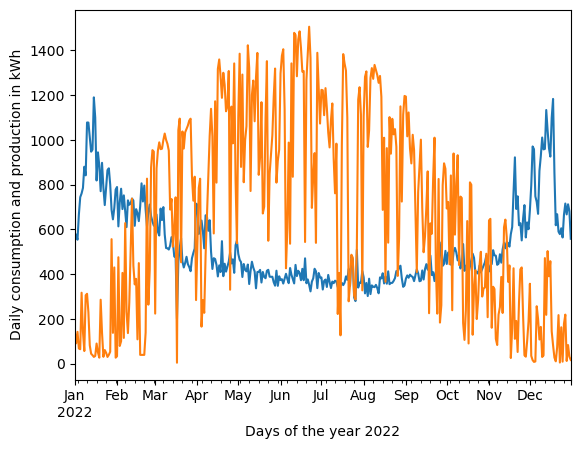

In [167]:
#Merging the rows in the dataframe to take the sum of all hours of a given day
combined_df3_daily = combined_df3.resample('D').sum()


##Plotting the daily production and consumption values
combined_df3_daily['Consumption'].plot()
combined_df3_daily['Production_values'].plot()

# Defining labels for the axes
plt.xlabel("Days of the year 2022")
plt.ylabel("Daily consumption and production in kWh")

plt.show()

After inspecting this graph four observations were made:
- The production curve has the typical convex shape. It demonstrates a peak during the summer months when solar radiation is abundant, while experiencing a decline during the winter months when solar intensity is comparatively lower.
- The consumption shows the typcial concave shape representing the increaced energy demand to heat in the winter time. This need is also met by electricity in this building through heat-pumps.
- The pattern of production and consumption therefore are in line with general knowledge about the characteristics of PV prodcution and energy consumption in countries of the northern hemisphere further away from the equator.
- The match between production and consumption is rather weak


Additionally a selection of weeks of the year were modelled to see the daily patterns more clearly and use the highest available reslution of time. You can change the number of the week to see differe


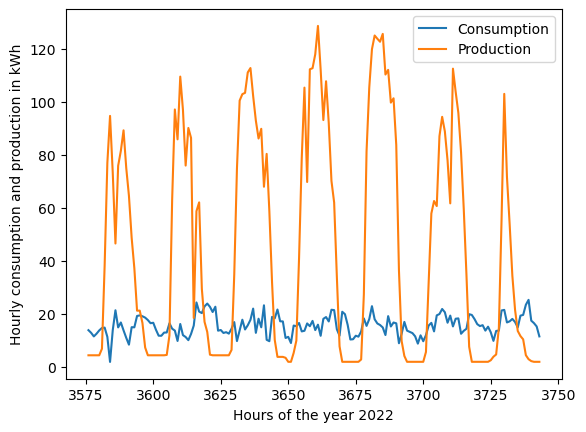

In [168]:
#Creating a new df where timestamp is a coloumn and not in the index
combined_df4 = combined_df3
combined_df4 = combined_df4.reset_index()

##Creating example weeks to model daily behaviour
combined_df4['week_number'] = combined_df4['Tijdstip'].dt.isocalendar().week
week_df = combined_df4[combined_df4['week_number']==22]


##Plot the weeks
week_df['Consumption'].plot()
week_df['Production_values'].plot()

# Defining labels for the axes
plt.xlabel("Hours of the year 2022")
plt.ylabel("Hourly consumption and production in kWh")

# Add a legend
plt.legend(['Consumption', 'Production'])

plt.show()

 <h2> Performing analysis on the understand the status quo of the building  </h2>

 <h3> Was the assumption correct that the house is energy positive? </h3>

In [169]:
production_sum_yearly= combined_df3['Production_values'].sum()
print(f'Yearly prodcution = {round(production_sum_yearly)}')

yearly_consumption = combined_df3['Consumption'].sum()
print(f'Yearly consumption is = {round(yearly_consumption)}')

Yearly prodcution = 242131
Yearly consumption is = 192643


Finding a yearly production of 242 MWh and a yearly consumption of 193 MWh cleary shows that the house is indeed net energy positive. 

 <h3> What was the self consumption ratio (SCR) of the building in 2022? </h3>

To find the SCR the following formula was applied, which was derived from a paper by Quoilin et al. (2016):

$SCR = \frac{E_{SC}}{E_{PV}}$

To apply this formula the self consumed electricity needs to be determined. This was done by applying the following logic: 

**self-consumed electricity = prodcution - feed-in**

In [170]:
feed_in_sum_yearly= feed_in_df['Waarde'].sum()
print(f'Yearly feed-in is = {round(feed_in_sum_yearly)}')

Yearly feed-in is = 179943


Using the yearly production value that was previously establised the following was found: 

SCR = (242131 - 179943)/ 242131 = 0.2568

**Expressed as a percentage it can be said that the building had an estimated self consumption ratio of 25.68%.**

 <h3> What was the self sufficiency ratio (SSR) of the building in 2022? </h3>

To find the SSR the following formula was applied, which was derived from a paper by Quoilin et al. (2016):

$SSR = \frac{E_{SC}}{E_{load}}$

The load i.e. consumption was established earlier at 192643 kWh as well as the self-consumed energy at 62188 kWh
Therefore it the following result is found:

SSR = 62188 / 192643 = 0.3228

**Expressed as a percentage it can be said that the building had an estimated self suffiency ratio of 32.28%.**

 <h2> Performing analysis on the understand the effect of the existing battery capacity </h2>

The building already has two batteries with 35kWh capacity each installed. The batteries objective is to perform peak-shaving. The aim of this analysis is to see how the batteries have influenced the SCR and SSR of the building. For this it was assumed that the battery only charged on surplus electricity prodcution and only discharged to met the load of the building. In other words, the battery is assumed not exchange energy with the grid directly.

To model how the house would have performed on SCR and SSR it was assumed that:
- all the electricity that the battery charged would have otherwise went into the grid.
- all the electricity that the battery discharged would have otherwise come from the grid.

The battery data was provided by iWell and needed to be harmonised with the building-dataset due to different time resultions.

In [171]:
#importing the two battery csv files
battery_facility_1 = pd.read_csv('/Users/lennartwittstock/Downloads/Thesis/Data/Battery_data/20.10.001_2022-01-01_2023-01-01.csv', sep=",")
battery_facility_2 = pd.read_csv('/Users/lennartwittstock/Downloads/Thesis/Data/Battery_data/20.10.002_2022-01-01_2023-01-01.csv', sep=",")

#merging the dataframes horizontally based on time
batteries_combined_df = pd.merge(battery_facility_2, battery_facility_1, on='_time')

#Taking the sum of both import and export columns
batteries_combined_df['Battery_import_sum']= batteries_combined_df['BatteryImportKwh_y'] + batteries_combined_df['BatteryImportKwh_x']
batteries_combined_df['Battery_export_sum']= batteries_combined_df['BatteryExportKwh_y'] + batteries_combined_df['BatteryExportKwh_x']

#Delete the columns that are not needed 
batteries_combined_df.drop(columns=["result_x", 
                                    "table_x",
                                    "BatteryExportKwh_x", 
                                    'BatteryImportKwh_x',
                                    'result_y', 
                                    'table_y', 
                                    'BatteryExportKwh_y',
                                    'BatteryImportKwh_y'], 
                               inplace=True)

# Match the timestamp to the datetime format
batteries_combined_df['_time'] = pd.to_datetime(batteries_combined_df['_time'])

#Set the timestamp as index and merge the rows per hour
batteries_combined_df.set_index('_time', inplace=True)
battery_df_hourly = batteries_combined_df.resample('60min').sum()

#Delete the hour from 2021
battery_df_hourly.drop("2021-12-31 23:00:00+00:00", axis = "index", inplace = True)

#create a common column name for time for both dataframes
battery_df_hourly = battery_df_hourly.rename_axis('Time')
combined_df3= combined_df3.rename_axis('Time')

# Remove the timezone awareness from the index
battery_df_hourly.index = battery_df_hourly.index.tz_localize(None)

#Merge the battery dataframe with the dataframe with the rest of the building data
bulding_and_battaery_df = pd.merge(battery_df_hourly, combined_df3, left_index=True, right_index=True)

# Finding the net-battery activity (There are many hours where the battery both imports and exports electrcity)
for index, row in bulding_and_battaery_df.iterrows():
    
    Battery_import_sum = row['Battery_import_sum']
    Battery_export_sum = row['Battery_export_sum']
    
    if Battery_import_sum > Battery_export_sum:
        Battery_import_sum -= Battery_export_sum
        Battery_export_sum = 0
    elif Battery_import_sum < Battery_export_sum:
        Battery_export_sum -= Battery_import_sum
        Battery_import_sum = 0
    elif Battery_import_sum == Battery_export_sum:
        Battery_import_sum = 0
        Battery_export_sum = 0
        
    bulding_and_battaery_df.at[index,'Battery_import_sum'] = Battery_import_sum
    bulding_and_battaery_df.at[index,'Battery_export_sum'] = Battery_export_sum

#Adding battery activities to the feed-in and usage values
for index, row in bulding_and_battaery_df.iterrows():
        Battery_import_sum = row['Battery_import_sum']
        Battery_export_sum = row['Battery_export_sum']
        feed_in = row["Feed_in_values"]
        usage = row["Usage_values"]
        
        feed_in += Battery_import_sum
        usage += Battery_export_sum * 0.85
        
        bulding_and_battaery_df.at[index,"Feed_in_values"] = feed_in
        bulding_and_battaery_df.at[index, "Usage_values"] = usage

Based on this new dataframe the calculations for SCR and SSR were repeated to find the effect of the existing batteries. The production of electricity is not effected by the batteries whereas the interchange with the grid as well as the consumption is effected. The effect on the consumption comes to the round-trip effiency of the batteries.

In [172]:
feed_in_yearly_cleaned = bulding_and_battaery_df['Feed_in_values'].sum()
print(f'Yearly feed-in CLEANED = {round(feed_in_yearly_cleaned)}')

#create an updated row for consumption
bulding_and_battaery_df['Consumption'] = ( 
    bulding_and_battaery_df['Usage_values'] 
    + bulding_and_battaery_df['Production_values'] 
    - bulding_and_battaery_df['Feed_in_values']
    )
#print(bulding_and_battaery_df)

consumption_sum_yearly_cleaned = bulding_and_battaery_df['Consumption'].sum()
print(f'Yearly consumption CLEANED = {round(consumption_sum_yearly_cleaned)}')

Yearly feed-in CLEANED = 183848
Yearly consumption CLEANED = 191527


SCR ratio without the presence of the two batteries i.e. with an updated feed-in value:
SCR = (242131 - 183848)/ 242131 = 0.2407

Expressed as a percentage it is estmated that without the presence of the batteries the building would have had a SCR of 24.07%


SSR ratio without the presence of the two batteries i.e. with an updated feed-in value:
SCR = (242131 - 183848)/ 191527 = 0.3043 
Expressed as a percentage it is estmated that without the presence of the batteries the building would have had a SSR of 30.43%


We can therefore note that the presence of the batteries increased
- SCR from 24.07% to 25.68% $\Delta$ = 1.61 percentage points or 6.69% 
- SSR from 30.43% to 32.28% $\Delta$ = 1.85 percentage points or 6.08%

 <h2> Manipulation the data to model the effect of additional battery capacity on SCR and SSR  </h2>

In this step a model was established to understand how battery-capacity soley dedicated to increasing the self-consumption ratio would impact SCR and SSR. 

The battery acts according to rules derived from Quoilin et al. (2016):
- At the beginning of the year the battery is assumed to be empty.
- When the solar production surpassed the consumption and the battery is not fully charged the battery will charge the surplus energy until the production is no longer above consumption or the battery has reached its designated capacity. 
- When the battery is not empty and the consumption surpasses the production the battery will discharge until the production matches or surpassed the capacity again or the battery has emptied itself.
- All energy flows that leave the battery will be multiplied by the round-trip efficiency to determine the actual output, which aims to model the storage losses. 

To model this behaviour the following code was used:

In [173]:
# Adding a new row for the charge of the hypothetical battery: 
combined_df3['Battery_Charge']= 0

# Defining parameters of the battery
battery_max_capacity = 250
previous_charge = 0
round_trip_effiency = 0.85

for index, row in combined_df3.iterrows():
    production = row["Production_values"]
    consumption = row["Consumption"]
    battery_charge = previous_charge
    feed_in = row["Feed_in_values"]
    usage = row["Usage_values"]
    
    if production - consumption > 0 and battery_charge != battery_max_capacity:
        if (battery_max_capacity - battery_charge) > (production - consumption):
            battery_charge += (production - consumption)
            feed_in -= (production - consumption)
        elif (battery_max_capacity - battery_charge) < (production - consumption):
            battery_charge = battery_max_capacity
            feed_in -= (battery_max_capacity - previous_charge)
        
    elif consumption - production > 0 and battery_charge > 0:
        if (consumption - production) <= battery_charge:
            battery_charge -= (consumption - production)
            usage -= (consumption - production) * round_trip_effiency
        elif (consumption - production) > battery_charge:
            battery_charge = 0
            usage -= previous_charge * round_trip_effiency
        
   
    combined_df3.at[index, "Battery_Charge"] = battery_charge
    combined_df3.at[index, "Feed_in_values"] = feed_in
    combined_df3.at[index, "Usage_values"] = usage
    
    # Updating the previous charge for the next iteration
    previous_charge = battery_charge

#calculate self consumption ratio
SCR = (combined_df3["Production_values"].sum() - combined_df3["Feed_in_values"].sum())/combined_df3["Production_values"].sum()
print(f'With an additional battery capacity of {battery_max_capacity}kWh a SCR of {round((SCR *100),2)}% is estimated.')

#calculate self suffiency ratio
SSR = (combined_df3["Production_values"].sum() - combined_df3["Feed_in_values"].sum())/combined_df3["Consumption"].sum()
print(f'With an additional battery capacity of {battery_max_capacity}kWh a SSR of {round((SSR *100),2)}% is estimated.')

With an additional battery capacity of 250kWh a SCR of 44.06% is estimated.
With an additional battery capacity of 250kWh a SSR of 55.38% is estimated.


This function was then repeatably used with different values for the capacity of the battery and the resuluts were saved in a dataframe and the Dataframe was plotted.

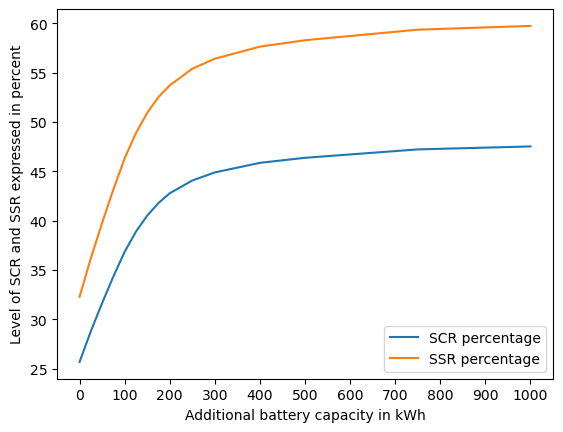

In [174]:
# Define the data as a list of dictionaries
data = [
    {'additional_capacity_kWh': 0, 'SCR_percentage': 25.68, 'SSR_percentage': 32.28},
    {'additional_capacity_kWh': 25, 'SCR_percentage': 28.79, 'SSR_percentage': 36.19},
    {'additional_capacity_kWh': 50, 'SCR_percentage': 31.64, 'SSR_percentage': 39.77},
    {'additional_capacity_kWh': 75, 'SCR_percentage': 34.34, 'SSR_percentage': 43.16},
    {'additional_capacity_kWh': 100, 'SCR_percentage': 36.84, 'SSR_percentage': 46.31},
    {'additional_capacity_kWh': 125, 'SCR_percentage': 38.88, 'SSR_percentage': 48.86},
    {'additional_capacity_kWh': 150, 'SCR_percentage': 40.5, 'SSR_percentage': 50.91},
    {'additional_capacity_kWh': 175, 'SCR_percentage': 41.78, 'SSR_percentage': 52.51},
    {'additional_capacity_kWh': 200, 'SCR_percentage': 42.77, 'SSR_percentage': 53.7},
    {'additional_capacity_kWh': 250, 'SCR_percentage': 44.06, 'SSR_percentage': 55.38},
    {'additional_capacity_kWh': 300, 'SCR_percentage': 44.88, 'SSR_percentage': 56.4},
    {'additional_capacity_kWh': 400, 'SCR_percentage': 45.85, 'SSR_percentage': 57.62},
    {'additional_capacity_kWh': 500, 'SCR_percentage': 46.36, 'SSR_percentage': 58.27},
    {'additional_capacity_kWh': 750, 'SCR_percentage': 47.21, 'SSR_percentage': 59.34},
    {'additional_capacity_kWh': 1000, 'SCR_percentage': 47.51, 'SSR_percentage': 59.72}
]

# Create the DataFrame
battery_sensitivity_df = pd.DataFrame(data)

# Plotting the columns "SCR_percentage" and "SSR_percentage"
plt.plot(battery_sensitivity_df['additional_capacity_kWh'], battery_sensitivity_df['SCR_percentage'])
plt.plot(battery_sensitivity_df['additional_capacity_kWh'], battery_sensitivity_df['SSR_percentage'])

# Defining labels for the axes
plt.xlabel("Additional battery capacity in kWh")
plt.ylabel("Level of SCR and SSR expressed in percent")

# Add a legend
plt.legend(['SCR percentage', 'SSR percentage'])

plt.xticks(range(0,1001,100))

plt.show()

Through this analysis it becomes apparent that there are significant increases in the SCR of the building to be made for the the first 100 to 200 kWh of additional battery capacity soley dedicated to increasing the SCR. Then however, an inflection point occures where additional capacity has almost no additional benefit to the self-consumption ratio and self suffiency ratio. In economic terms it could be said that the marginal addition of battery capacity has almost no benefit.

An economic analysis is not part of this thesis. It can however be said that even if the financial reward for feeding electricity is set to zero it will most likely not be economical to add more than 250kWh battery capacity to the building.